<a href="https://colab.research.google.com/github/dhrits/LLM-Engineering-Foundations-to-SLMs/blob/main/07_Fine-tuning/Fine_tuning_Llama_3_1_8B_Instruct_on_a_Translation_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ⚠ IMPORTANT ⚠

You will need at least 18GB of VRAM (GPU RAM) to run this notebook.

If you're running this locally - please ensure you have the correct hardware to support the fine-tuning.

# Task Fine-tuning a GPT-style model using `peft`, `transformers` and `bitsandbytes`

In the following notebook, we'll task fine-tune a GPT-style model on the summarization task using:

- [QLoRA](https://arxiv.org/pdf/2305.14314.pdf)/[LoRA](https://arxiv.org/pdf/2106.09685.pdf)

The basic idea is that we will fine-tune an "adapter" which will represent a small subset of trainable weights on our task. This will allow us to instruct-tune a comparatively large model with consumer level resources.

The model we'll be instruct-tuning today is [`meta-llama/Llama-3.1-8B-Instruct`](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)!

> NOTE: The official Llama 3.1 weights are gated behind a EULA - if you *HAVE NOT* accepted the terms and conditions for the Meta Llama models - please use the [NousResearch](https://huggingface.co/NousResearch/Meta-Llama-3.1-8B-Instruct) variant.

### Homework Sections

The notebook will be broken into the following sections:

1. Breakout Room #1:
  - Task #1: Loading the Model
    - 👪❓ Discussion Question #1
    - ❓ Question #1
    - ❓ Question #2
2. Breakout Room #2:
  - Task #2: Data and Data Prep.
    - 🏗️ Activity #1
  - Task #3: Setting up PEFT LoRA
    - ❓ Question #3
  - Task #4: Training the Model
    - ❓ Question #4
    - ❓ Question #5
  - Task #5: Share Your Model!
    - ❓ Question #6

There are a total of 6 Questions, all of which must be completed to receive full marks for the homework.


#### 👪❓ Discussion Question #1:

What makes Llama 3.1 8B Instruct a good model to use for a translation task?

Llama 3.1 8B Instruct has already been pretrained on a massive amount of data in an unsupervised manner. Thereafter, it has also been instruction-finetuned on a large number of instruction finetuning datasets (based on the model-card). Looking at the evaluation results on the model-card, this model also performs decently on Multilingual MGSM (CoT) datasets. All of these make it a decent model to finetune for this task.

### Overview of PEFT and LoRA:

Based on some awesome research [here](https://github.com/huggingface/peft), we can leverage techniques like PEFT and LoRA to train/fine-tune large models a lot more efficiently.

It can't be explained much better than the overview given in the above link:

```
Parameter-Efficient Fine-Tuning (PEFT) methods enable efficient adaptation of
pre-trained language models (PLMs) to various downstream applications without
fine-tuning all the model's parameters. Fine-tuning large-scale PLMs is often
prohibitively costly. In this regard, PEFT methods only fine-tune a small
number of (extra) model parameters, thereby greatly decreasing the
computational and storage costs. Recent State-of-the-Art PEFT techniques
achieve performance comparable to that of full fine-tuning.
```

# 🤝 Breakout Room #1

### Setting Up Dependencies

We'll start by setting up the dependencies!

In [1]:
!pip install -qU bitsandbytes datasets accelerate loralib peft transformers trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 req

We'll first verify we're in a GPU instance.

In [2]:
import torch
torch.cuda.is_available()

True

Time to import some dependencies!

In [3]:
import os

import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig

## Task #1: Loading the Model

In the following task you will be expected to load the model from Hugging Face.

### Overview of Quantization:

Quantization is ultimately a simple concept with some very clever and tricky techniques that power it.

In today's notebook, we'll be exclusively focusing on the `bitsandbytes` quantization strategy which includes the idea of `k-bit` training.

Let's look at the QLoRA paper's definition of quantization:


```
Quantization is the process of discretizing an input from a representation that
holds more information to a representation with less information
```

Easy enough then!

Let's take a look at what that actually means.

### Block-wise k-bit Quantization

Ultimately, the QLoRA paper relies on a very specific form of quantization that relies on a few key ideas:

1. Model weights are mostly normally distributed
2. NF4 is a information-theoretically optimal data-type (this was later found to be [untrue](https://x.com/Tim_Dettmers/status/1668649436724199425?s=20), but NF4 is close to *empirically* optimal)


Let's think about quantization from a very high level - and use some oversimplifications to understand what's really happening under the hood.

In essence, we can think of quantization as placing a pin on the number line (our quantization constant) and then expressing a low-precision zero-centered size-64 block range around that pinned number. Exploiting the fact that our weights are normally distributed and that we scale them to be in the range [-1, 1], this lets use use our NF4 datatype to roughly optimally express our high precision weights in a low precision format. While we still do need *some* higher precision numbers - this process lets use represent many numbers in low precision for the cost of 1 number in high precision.

However, we can take it one step further - and we can actually quantize the range of quantization constants we wind up with as well! This winds up saving us ~0.373 bits per parameter.

Leveraging the work done in [QLoRA](https://arxiv.org/pdf/2305.14314.pdf) means we need to set some specific hyper-parameters for our [`quantization_config`](https://github.com/huggingface/transformers/blob/2fc33ebead50383f7707b17f0e2a178d86347d10/src/transformers/utils/quantization_config.py#L151).

- `load_in_4bit` - we'll want to set this to true so we can load and train our model on a single 40GB GPU.
- `bnb_4bit_quant_type` - setting this to the desired format of `nf4` will ensure we're using the most memory efficient datatype for 4bit storage.
- `bnb_double_quant` - setting this to true will save us memory by quantizing the quantization config
- `bnb_4bit_compute_dtype` - since we will not use a 4-bit representation to compute, we need to provide a desired format for our compute type so our weights can be upcast to something while we flow information through our network.



In [4]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

#### ❓Question #1:

What exactly is happening in the double quantization step?

> NOTE: You can use the paper provided to find the answer!

Instead of simply quantizing the model weights, QLora also quantizes the quantization parameters; the scaling factors and zero-points; which are used to quantize the model weights.

The weights themselves can be stored in a 4-bit format. Traditionally, the scales and zero points would be stored in float16 format (which would take up a lot of space). Double quantization further quantizes these scaling factors and zero points so they can be stored in 8-bit or lower datatypes.

### Authentication

Before loading our model - we'll need to provide our Hugging Face token!

In [6]:
from huggingface_hub import notebook_login

notebook_login()

Now we can load the model.

In [7]:
model_id = "NousResearch/Meta-Llama-3.1-8B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto',
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/50.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [9]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

#### Bonus Question:

Why do we do these two tokenizer modifications?

> NOTE: This is not required for marks, and should be completed *outside* of class as additional learning

Models like Llama don't typically rely on padding tokens during causal generation or inference. However, when finetuning them, we need to do this finetuning in batches. In this case, we need to ensure each batch of data is the same size (for parallel processing as a tensor) and so we need to define a default padding token.

Padding on the right is a good default for most languages as we can easily mask out the rest of the sentence.



### Model Architecture

It's important to observe the model's construction!

This one should look familiar!

In [10]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps

In [11]:
model.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "NousResearch/Meta-Llama-3.1-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold

#### ❓Question #2:

![image](https://i.imgur.com/N8y2crZ.png)

Label the image with the appropriate layer from `meta-llama/Llama-3.1-8B-Instruct`'s architecture.

- EXAMPLE - Layer Norm:
  - `(input_layernorm): LlamaRMSNorm()`
  - `(post_attention_layernorm): LlamaRMSNorm()`
  - `(norm): LlamaRMSNorm()`


- Layer Norm:
    * `(input_layernorm)`: `LlamaRMSNorm()`
    * `(post_attention_layernorm)`: `LlamaRMSNorm()`
    * `(norm)`: `LlamaRMSNorm()`
- Feed Forward:
    * `(mlp)`: `LlamaMLP(`
    * `(gate_proj)`: `Linear4bit(in_features=4096, out_features=14336, bias=False)`
    * `(up_proj)`: `Linear4bit(in_features=4096, out_features=14336, bias=False)`
    * `(down_proj)`: `Linear4bit(in_features=14336, out_features=4096, bias=False)`
    * `(act_fn)`: `SiLU()`
- Masked Multi Self-Attention:
    * (`self_attn)`: `LlamaSdpaAttention(`
    * `(q_proj)`: `Linear4bit(in_features=4096, out_features=4096, bias=False)`
    * `(k_proj)`: `Linear4bit(in_features=4096, out_features=1024, bias=False)`
    * `(v_proj)`: `Linear4bit(in_features=4096, out_features=1024, bias=False)`
    * `(o_proj)`: `Linear4bit(in_features=4096, out_features=4096, bias=False)`
- Text & Position Embed: `(rotary_emb)`: `LlamaRotaryEmbedding()`
- Text Prediction: `(lm_head)`: `Linear(in_features=4096, out_features=128256, bias=False)`

# 🤝 Breakout Room #2

## Task #2: Data and Data Preparation

Since we'll be focusing on translation fine-tuning - we'll need to find a translation dataset!

There are a few good examples available to use on the Hugging Face [dataset](https://huggingface.co/datasets?task_categories=task_categories:translation&sort=trending) hub - let's check a few of them out!

> NOTE: The link above is pre-filtered to include datasets with the translation tag

### Summarization Datasets

Let's see what is available for us:

- [`deepmind/code_contests`](https://huggingface.co/datasets/deepmind/code_contests)
  - this dataset is focused on translating natural language (in English) to code solutions to that problem.
- [`PNLPhub/FarsInstruct`](https://huggingface.co/datasets/PNLPhub/FarsInstruct)
  - this dataset takes a large number of categories and provides Farsi instructions and response pairs.
- [`Helsinki-NLP/opus_books`](https://huggingface.co/datasets/Helsinki-NLP/opus_books)
  - this contains passages from books in pairs of languages
- [`dtthanh/gen_z_translation`](https://huggingface.co/datasets/dtthanh/gen_z_translation)
  - Contains Natural Language to Gen-Z Language pairs.

As you can see, we have a number of different options to choose from - and hopefully you can additionally see just how broad the term *translation* can be!

Our first step will be to download our dataset from the HuggingFace hub!

In [12]:
from datasets import load_dataset

genz_dataset = load_dataset("dtthanh/gen_z_translation")

README.md:   0%|          | 0.00/337 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/55.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/821 [00:00<?, ? examples/s]

Let's check how many items we have in each of our training, validation, and test subsets.

In [13]:
genz_dataset["train"]

Dataset({
    features: ['id', 'English', 'Gen-Z'],
    num_rows: 821
})

We can now format our dataset into a training test split!

In [14]:
genz_dataset_train = genz_dataset["train"].train_test_split(test_size=0.2)

In [15]:
genz_dataset_test = genz_dataset_train["test"].train_test_split(test_size=0.5)

In [16]:
from datasets import DatasetDict

genz_dataset = DatasetDict({
    "train" : genz_dataset_train["train"],
    "test" : genz_dataset_test["test"],
    "validation" : genz_dataset_test["train"]
})

In [17]:
genz_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'English', 'Gen-Z'],
        num_rows: 656
    })
    test: Dataset({
        features: ['id', 'English', 'Gen-Z'],
        num_rows: 83
    })
    validation: Dataset({
        features: ['id', 'English', 'Gen-Z'],
        num_rows: 82
    })
})

Let's look at a single example to see the format we're working with!

In [18]:
genz_dataset["train"][0]

{'id': '798',
 'English': "His jokes are always on point; he's very funny.",
 'Gen-Z': " His jokes are always on point, he's so funny."}

### Instruction Templating

Instruction-tuned LLMs will typically use a specific template when being trained to accomodate various instruction sets, as well as for better chat and multi-turn use-cases.

Here is the format as indicated in Meta's [llama3](https://github.com/meta-llama/llama3?tab=readme-ov-file#instruction-tuned-models) repository, as well as the intuition behind the prompt template.

> The fine-tuned models were trained for dialogue applications. To get the expected features and performance for them, a specific formatting defined in ChatFormat needs to be followed: The prompt begins with a `<|begin_of_text|>` special token, after which one or more messages follow. Each message starts with the `<|start_header_id|>` tag, the role `system`, `user` or `assistant`, and the `<|end_header_id|>` tag. After a double newline `"\n\n"` the contents of the message follow. The end of each message is marked by the `<|eot_id|>` token.

Here is an example of this format:

```
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Please convert the following text into the 'Gen-Z-ified' translation<|eot_id|><|start_header_id|>user<|end_header_id|>

[ORIGINAL_TEXT]
I'm tired of this weather. I wish we had some sunshine.
[END_ORIGINAL_TEXT]<|eot_id|><|start_header_id|>assistant<|end_header_id|>

I'm so over this weather. Can we get some sunshine, please?<|eot_id|>
```

> NOTE: We're adding our own special token sequences here in `[ORIGINAL_TEXT]` and `[END_ORIGINAL_TEXT]` to encourage the model to better understand our context, but these are not special tokens that are already understood by the model!

#### 🏗️ Activity #1: Creating the `create_prompt` function

We'll create a function that will take a row of our dataset, along with a default False flag that creates the prompt in the format expressed above.

In [19]:
INSTRUCTION_PROMPT_TEMPLATE = """\
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You must translate the text provide into Gen-Z-ified English. You must not provide anything but the translation itself. <|eot_id|><|start_header_id|>user<|end_header_id|>

[ORIGINAL_TEXT]
{original_text}
[END_ORIGINAL_TEXT]<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

RESPONSE_TEMPLATE = """\
{translation}<|eot_id|><|end_of_text|>"""

In [20]:
def create_prompt(sample, include_response = True):
  """
  Parameters:
    - sample: dict representing row of dataset
    - include_response: bool

  Functionality:
    This function should build the Python str `full_prompt`.

    If `include_response` is true, it should include the translation -
    else it should not contain the translation (useful for prompting) and testing

  Returns:
    - full_prompt: str
  """
  full_prompt = INSTRUCTION_PROMPT_TEMPLATE.format(original_text=sample["English"])

  if include_response:
    full_prompt += RESPONSE_TEMPLATE.format(translation=sample["Gen-Z"])

  return full_prompt

In [21]:
print(create_prompt(genz_dataset["test"][1]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You must translate the text provide into Gen-Z-ified English. You must not provide anything but the translation itself. <|eot_id|><|start_header_id|>user<|end_header_id|>

[ORIGINAL_TEXT]
The party was excellent; we had a lot of fun.
[END_ORIGINAL_TEXT]<|eot_id|><|start_header_id|>assistant<|end_header_id|>That party was lit, we had such a great time.<|eot_id|><|end_of_text|>


In [22]:
def generate_response(prompt, model, tokenizer):
  """
  Parameters:
    - prompt: str representing formatted prompt
    - model: model object
    - tokenizer: tokenizer object

  Functionality:
    This will allow our model to generate a response to a prompt!

  Returns:
    - str response of the model
  """

  # convert str input into tokenized input
  encoded_input = tokenizer(prompt,  return_tensors="pt")

  # send the tokenized inputs to our GPU
  model_inputs = encoded_input.to('cuda')

  # generate response and set desired generation parameters
  generated_ids = model.generate(
      **model_inputs,
      max_new_tokens=256,
      do_sample=True,
      pad_token_id=tokenizer.eos_token_id
  )

  # decode output from tokenized output to str output
  decoded_output = tokenizer.batch_decode(generated_ids)

  # return only the generated response (not the prompt) as output
  return decoded_output[0].split("<|end_header_id|>")[-1]

In [23]:
generate_response(create_prompt(genz_dataset["test"][1], include_response=False),
                  model,
                  tokenizer)

'\n\nThe party was lit; we had a blast.<|eot_id|>'

In [24]:
# Ground Truth Summary
genz_dataset["test"][1]["Gen-Z"]

'That party was lit, we had such a great time.'

Let's try another just to see how the model responds to a different prompt.

In [25]:
generate_response(create_prompt(genz_dataset["test"][3], include_response=False),
                  model,
                  tokenizer)

"\n\nI'm low-key obsessed with their skills and talent, it's giving me major goals!<|eot_id|>"

In [26]:
# Ground Truth Summary
genz_dataset["test"][3]["Gen-Z"]

"That's so fire, I'm impressed by their skills and talent."

The response, is pretty okay! It doesn't exactly match our desired format - but it does a decent job!

Let's see how fine-tuning can improve these responses.

### Required Post Processing

Finally, we need to apply some post-processing on the 4-bit model to enable training, let's freeze all our layers, and cast the layer-norm in `float32` for stability. We also cast the output of the last layer in `float32` for the same reasons.

Instead of doing this manually, of course, we can use the helper function `prepare_model_for_kbit_training`! You can look at the source code [here](https://github.com/huggingface/peft/blob/18773290938fc632c42ac49f462ab34bd1abd3ea/src/peft/utils/other.py#L67)

In [27]:
from peft import prepare_model_for_kbit_training
model.config.use_cache = False
model = prepare_model_for_kbit_training(model)

## Task #3: Setting up PEFT LoRA

Here comes the magic with `peft`! Let's load a `PeftModel` and specify that we are going to use low-rank adapters (LoRA) using `get_peft_model` utility function from `peft`.

#### Helper Function to Print Parameter %age

This is just a helper function to print out just how much LoRA reduces the number of trainable parameters.

In [28]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

#### Initializing LoRA Config

There's a lot to unpack here - so let's talk about the main parameters:

- `r`: is the "rank" of the two decomposed matrices we'll be using to represent our weight matrix. In reality, this is the dimension of the decomposed matrices.

Here is an exerpt from the paper to help provide context for the selected `r`

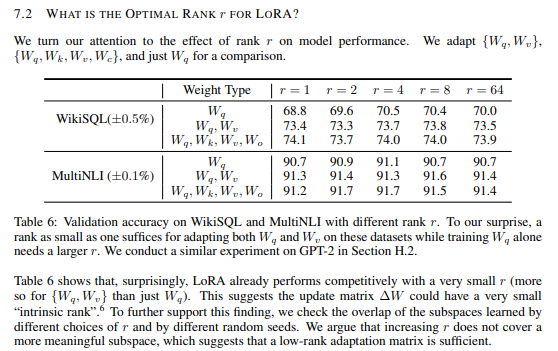


- `target_modules`: As LoRA can be applied to *any* weight matrix - we need to configure *which* module (weight matrix) it's being applied to. The LoRA paper suggests applying it to the Attention weights, but the QLoRA paper suggests we apply it to all Linear layers. Thus, we'll omit `target_module` from our hyper-parameters.


- `task_type`: This is a derived property. If you're using a causal model, this should be set to `CAUSAL_LM`. Please ensure this property is set based on your selected model.

Again, while this is the way we're leveraging LoRA in this notebook - it can be used in conjunction with many different models - and many different tasks. You can even use it for tasks like [token classification!](https://huggingface.co/docs/peft/task_guides/token-classification-lora)

In [29]:
from peft import LoraConfig, get_peft_model

# set our rank (higher value is more memory/better performance)
lora_r = 16

# set our dropout (default value)
lora_dropout = 0.1

# rule of thumb: alpha should be (lora_r * 2)
lora_alpha = 32

# construct our LoraConfig with the above hyperparameters
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM"
)

Now that we have our PEFT config - we need to convert our model into a PEFT model!

We can use the convenient helper function `get_peft_model` to do so.

Documentation found [here](https://github.com/huggingface/peft/blob/18773290938fc632c42ac49f462ab34bd1abd3ea/src/peft/mapping.py#L98)!

In [30]:
model = get_peft_model(
    model,
    peft_config
)

print_trainable_parameters(model)

trainable params: 41943040 || all params: 4582543360 || trainable%: 0.9152786281546499


In [31]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): 

#### ❓Question #3:

What modules (or groupings of layers) did we apply LoRA too - and how can we tell from the model summary?

The LoRA layers are applied to the (Masked) Self Attention and MLP layers. Specifically for `LlamaSdpaAttention` module, we apply LoRA to `q_proj`, `k_proj`, `v_proj`, `o_proj`. For `LlamaMLP` module, we have LoRA applied to `gate_proj`, `up_proj` and `down_proj`. This is visible in the module breakdown above where the these layers have the `lora_A` and `lora_B` adapter matrices as well as `lora_embedding_A` and `lora_embedding_B`.

## Task #4: Training the Model

Now we'll be training our model with the created dataset!



### Setting up Training

The `SFTConfig` class contains all the usual suspects - these are the same hyper-parameters you know and love from from previous notebooks!

If you're running into CUDA memory issues - please modify both the `per_device_train_batch_size` to be lower, and also reduce `r` in your LoRAConfig. You'll need to restart and re-run your notebook after doing so.

In [41]:
from trl import SFTConfig

max_seq_length = 1024

args = SFTConfig(
  output_dir = "llama3181binstruct_translate_genz",
  #num_train_epochs=5,
  max_steps = 100, # comment out this line if you want to train in epochs
  per_device_train_batch_size = 1,
  warmup_steps = 30,
  logging_steps=10,
  #evaluation_strategy="epoch",
  eval_strategy="steps",
  eval_steps=25, # comment out this line if you want to evaluate at the end of each epoch
  learning_rate=2e-4,
  lr_scheduler_type='cosine',
  dataset_kwargs={
        "add_special_tokens" : False,
        "append_concat_token" : False,
  },
  max_seq_length=max_seq_length,
  packing=True,
  report_to=None,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


#### ❓Question #4:

Describe what the following parameters are doing:

- `warmup_steps`
- `learning_rate`
- `lr_scheduler_type`

> NOTE: Feel free to consult the [documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) or other resources!

* `warmup_steps` - During model training, the optimization process slowly increases the learning rate (see below) of the model over a number of steps linearly from 0 to the desired learning rate. These number of steps are referred to as warmup_rate.
* `learning_rate` - This is one of the most important hyperparameters during the model training/finetuning process. While it is a bit of a simplification, during the training process, the optimization algorithm move the weights in the opposite direction of the gradient of the loss function with respect to these weights (parameters). The size of the step is known as the learning rate. If this learning rate is too large, the optimization process may "step over" the minimum of the function and if it is too small, the network may not learn (or learn very slowely). In this case of finetuning, the model is already well trained, so we use a very small learning rate so as not to let the model forget too much of what it already knows.
* `lr_scheduler_type` - The optimization learning rate need not be constant throughout the training. It is quite common to slowly increase the learning rate to the desired number. Or to increase the learning rate slowly and then decrease it throughout the training. Or even use a cyclical learning rate. Learning Rate schedulers (lr_scheduler_type) control this schedule of the learning rate.

In [39]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [42]:
from trl import SFTTrainer

trainer = SFTTrainer(
  model=model,
  peft_config=peft_config,
  tokenizer=tokenizer,
  formatting_func=create_prompt,
  args=args,
  train_dataset=genz_dataset["train"],
  eval_dataset=genz_dataset["validation"]
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:626: UserWarning: The passed formatting_func has more than one argument. Usually that function should have a single argument `example` which corresponds to the dictionary returned by each element of the dataset. Make sure you know what you are doing.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:428: UserWarning: You passed `packing=True` to the SFTTrainer/SFTConfig, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


> NOTE: The following cell should take ~5-7min. or so to complete on a T4 GPU with the pre-set hyper-parameters.

In [43]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
25,0.898500,0.606000
50,0.490800,0.487536
75,0.324300,0.465244
100,0.369500,0.451202


TrainOutput(global_step=100, training_loss=0.5734544515609741, metrics={'train_runtime': 90.7363, 'train_samples_per_second': 1.102, 'train_steps_per_second': 1.102, 'total_flos': 4636795522252800.0, 'train_loss': 0.5734544515609741, 'epoch': 2.0})

##### ❓ Question #5:

Is this training overfitting, underfitting, or neither?

What reasons do you have for this answer? How could you prevent this from happening?

Looking at the difference in loss between training and validation, the model is overfitting *a little* to the given data and objective (gen-z translation). Also technically, this is the point of PEFT finetuning i.e. creating a set of weights which help the model adapt to this specific task.

If we really wanted to prevent this, we could do a few things:

1. We could use a larger rank in our peft config. This would be somewhat equivalent to using a larger model which would help reduce any overfitting behavior.
2. We could adjust the learning rate to be lower which would make the learning process a little less aggressive.
3. We could increase the dropout in the Peft config.
4. We could train with more aggressive weight regularization (L2 regularization).

## Task #5: Share Your Model!

Normally, we would only seek to push the LoRA adapters to the hub. This is a lightweight and memory efficient way to push this model - as you can pull the base model down as part of the inference pipeline.

However, if you want to leverage the one-click-deploy features of Hugging Face, you'll need to first `merge_and_unload()` the model and push the resulting model to the hub. This process will merge the LoRA weights back into the base model.

> NOTE: If you run into issues during upload - please ensure you're using a HF Token with `WRITE` access!

In [44]:
trainer.push_to_hub("deman539/llama3181binstruct_gen-z_translate_v1")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


events.out.tfevents.1734204068.672ef1af73c4.417.1:   0%|          | 0.00/6.25k [00:00<?, ?B/s]

events.out.tfevents.1734203977.672ef1af73c4.417.0:   0%|          | 0.00/6.25k [00:00<?, ?B/s]

events.out.tfevents.1734204220.672ef1af73c4.417.2:   0%|          | 0.00/9.72k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.62k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/deman539/llama3181binstruct_translate_genz/commit/5bdaeab1db255862293a4b88203486c48f247880', commit_message='deman539/llama3181binstruct_gen-z_translate_v1', commit_description='', oid='5bdaeab1db255862293a4b88203486c48f247880', pr_url=None, repo_url=RepoUrl('https://huggingface.co/deman539/llama3181binstruct_translate_genz', endpoint='https://huggingface.co', repo_type='model', repo_id='deman539/llama3181binstruct_translate_genz'), pr_revision=None, pr_num=None)

### Compare Outputs

Let's see how our model fairs at this task, now!

In [45]:
merged_model = model.merge_and_unload()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:355: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [46]:
merged_model.push_to_hub("deman539/llama3181binstruct_gen-z_translate_v1", safe_serialization=True)

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.81G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/deman539/llama3181binstruct_gen-z_translate_v1/commit/1e7e1a36c516eaa42d6c1093d36d966209495778', commit_message='Upload LlamaForCausalLM', commit_description='', oid='1e7e1a36c516eaa42d6c1093d36d966209495778', pr_url=None, repo_url=RepoUrl('https://huggingface.co/deman539/llama3181binstruct_gen-z_translate_v1', endpoint='https://huggingface.co', repo_type='model', repo_id='deman539/llama3181binstruct_gen-z_translate_v1'), pr_revision=None, pr_num=None)

In [47]:
tokenizer.push_to_hub("deman539/llama3181binstruct_gen-z_translate_v1")

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/deman539/llama3181binstruct_gen-z_translate_v1/commit/de347b282e61dbe76fdd514c26a0ae747b08a599', commit_message='Upload tokenizer', commit_description='', oid='de347b282e61dbe76fdd514c26a0ae747b08a599', pr_url=None, repo_url=RepoUrl('https://huggingface.co/deman539/llama3181binstruct_gen-z_translate_v1', endpoint='https://huggingface.co', repo_type='model', repo_id='deman539/llama3181binstruct_gen-z_translate_v1'), pr_revision=None, pr_num=None)

#### ❓Question #6:

What does the `merge_and_unload()` method do?

> NOTE: Check out the [documentation](https://huggingface.co/docs/trl/v0.7.11/use_model) or the [source code](https://github.com/huggingface/peft/blob/096fe537370cf8a2cb55cc9bd05c7812ca919405/src/peft/tuners/lora/model.py#L685) to find out!

This method call basically gets rid of the extra added adapter layers (which were finetuned as part of the PEFT process) and instead merges those weights with the weights of the model these layers were adapting. This merged model is a normal transformer model, and as a consequence of adapter layer merging, can be more easily used for inference.

Of course the downside is that the model is significantly larger.

In [48]:
genz_dataset["test"][1]["English"]

'The party was excellent; we had a lot of fun.'

In [49]:
generate_response(create_prompt(genz_dataset["test"][1], include_response=False),
                  merged_model,
                  tokenizer)

'\n\nThe party was lit; we had a major turnt time.<|eot_id|>'

In [50]:
genz_dataset["test"][1]["Gen-Z"]

'That party was lit, we had such a great time.'

We can see that, directionally, our model is getting much closer to our desired results with only *100* steps of training.

Let's try another example to make sure it wasn't a fluke!

In [51]:
genz_dataset["test"][3]["English"]

"That's so amazing, I'm impressed by their skills and talent."

In [52]:
generate_response(create_prompt(genz_dataset["test"][3], include_response=False),
                  merged_model,
                  tokenizer)

"\n\nThat's straight fire, I'm low-key shook by their skills and talent.<|eot_id|>"

In [53]:
# Ground Truth Translation
genz_dataset["test"][3]["Gen-Z"]

"That's so fire, I'm impressed by their skills and talent."

As we can see - the translated result is closer to what we'd see in our training set!

We can also extend this to unseen examples!

In [54]:
new_prompt = {
    "English" : "What is the meaning of life, the universe, and everything?"
}

In [55]:
generate_response(create_prompt(new_prompt, include_response=False),
                  merged_model,
                  tokenizer)

"\n\nlike, what's the ultimate purpose of existence, the cosmos, and everything in between?<|eot_id|>"